In [10]:
import time
start = time.time()

In [11]:
#%%capture
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


You should consider upgrading via the 'c:\Users\91758\Desktop\Project5\SET5\Scripts\python.exe -m pip install --upgrade pip' command.


Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\91758\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91758\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91758\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\91758\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\91758\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\91758\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!

In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 7, 6

from copy import deepcopy
import seaborn as sns

import sys
sys.path.append('utils')
from utils import review_feature
rf = review_feature()
%matplotlib inline

In [13]:
from zipfile import ZipFile
import urllib.request
from io import BytesIO
folder = urllib.request.urlopen('https://s3.amazonaws.com/projex.dezyre.com/ecommerce-product-reviews-ranking-sentiment-analysis/materials/data.zip')
zipfile = ZipFile(BytesIO(folder.read()))
zipfile.namelist()

['data/test.csv',
 'data/test_ranked_output.csv',
 'data/test_ranked_output_new.csv',
 'data/test_withoutlabel.csv',
 'data/train.csv']

In [14]:
df = pd.read_csv(zipfile.open('data/train.csv'))

In [15]:
df

,product,answer_option,label
0,Accucheck,Fast and accurate delivery,0
1,Accucheck,As usual it is genuine,0
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0
3,Accucheck,fwegwrqdsdvwfg,0
4,Accucheck,These strips were as per my requirment,0
...,...,...,...
1671,Accucheck,Ft GM,0
1672,Accucheck,I like,0
1673,Accucheck,Nice price with long expiry,0
1674,Accucheck,Price & Service,0


## Analysis to understand per product who many informative and how many not informative reviews are there. 

In [16]:
label_analysis = pd.crosstab(df['product'],df['label'], margins='All')
label_analysis

label,0,1,All
product,,,
Accucheck,317,85,402
Becadexamin,53,27,80
Evion,89,33,122
Neurobion,286,137,423
SevenseascodLiverOil,60,22,82
Shelcal,262,126,388
Supradyn,50,23,73
shampoo,57,49,106
All,1174,502,1676


<AxesSubplot:xlabel='product'>

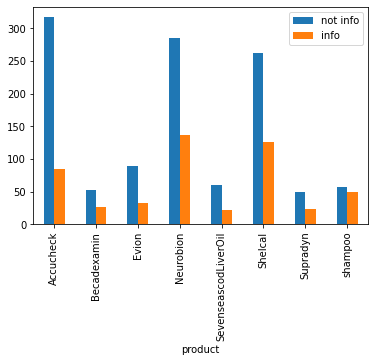

In [17]:
analysis = label_analysis.reset_index()
analysis.columns = ['product','not info', 'info', 'All']
analysis.iloc[:-1].plot(x="product", y=["not info", "info"], kind="bar")

## Lets check the length quality of reviews we have?

In [18]:
df['review_len'] = df['answer_option'].apply(lambda x: len(x.split()))

In [19]:
df

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0,20
3,Accucheck,fwegwrqdsdvwfg,0,1
4,Accucheck,These strips were as per my requirment,0,7
...,...,...,...,...
1671,Accucheck,Ft GM,0,2
1672,Accucheck,I like,0,2
1673,Accucheck,Nice price with long expiry,0,5
1674,Accucheck,Price & Service,0,3


In [20]:
checklen = []
for i in range(5,50, 5):
    checklen.append(len(df[ (df['review_len']>=i-5) & (df['review_len']<i)]))

In [21]:
checklen

[780, 603, 149, 65, 29, 22, 9, 6, 3]

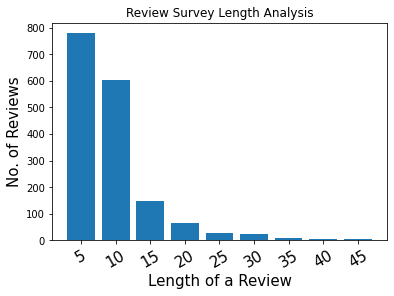

In [22]:
index = np.arange(len(checklen))
plt.bar(index, checklen)
plt.xlabel('Length of a Review', fontsize=15)
plt.ylabel('No. of Reviews', fontsize=15)
plt.xticks(index, range(5,50,5), fontsize=15, rotation=30)
plt.title('Review Survey Length Analysis')
plt.show()

## We have a fair amount of both details reviews (having length >=5) and short reviews (having length <5)

## Data Preprocessing

![datapreprocessing](Photos/datapreprocessing.png)

## Stage1: Language Detection

In [23]:
bad_reviews = []
for indx in df.index:
    review = df.at[indx, 'answer_option']
    try:
        b = rf.language_detection(review)
        if b == 'hi' or b == 'mr':
            bad_reviews.append(indx)
    except:
        bad_reviews.append(indx)
        print("Language exception for:", review)

Language exception for: 😕🤔😕🤣😕🤣😢😨😔😭😃😁😣😨😁🤦‍♂️😨☺😣😔😨😛🤦‍♂️😢☺👍🙈😨😕😔😊😢😕😔🙈😨😣🤦‍♂️👍😁🤦‍♂️🙈😁🤦‍♂️😂😕😔😊😨👍😂😢👍😂🙈😢👍😂😭👍😂😭😕🙈👍😕😂☺😕😂😂😣😂😕👍😢😕🤦‍♂️😂😢🤔🙈😕🤦‍♂️🙈😢🤔😂🤦‍♂️🙈🤔😔😣😣👆🙈🤔😔😕😕😨🤣😔😕🙈😊😨😣😣🙈😊😕😂🤔😕😢🤔👍🤣😨😕😭😨😕😭😨😕😭😕👍😭😕😕🤣👍😁😭👍👍😭😕😣🙈😕😣😢😣😣😨😣😛😨😭😣😢😭😨😛😨🤣😢😨😂😊🤔😊🙈🙈🙈😭🐂🐎🐷🐎🐂🐈🐱🐮🦓🐱🐄🦌🦔🌹🥀⚘🌸🏵🌲🌷🌸⚘🌱🥔🍑🍓🍆🥝🍐🥑🥕🍆🍏🥝🍓🥔🥝🍆🥔🥑🥝🥝🥝🍒🥔🥑🥝🍏🍏🥑🥔🍐🍏🥑🥔🥔🥔🍆🍏🍏🍓🍇🥕🍏🍓🍏🍓🍏🥔🍐🍐🥔🍐🥔🥔🍐🥔🥑🍓🍏🍓🥝🍓🥑🍓🥑🍓🥑🥕🍐🥕🍏🍓🍇🍑🍈🥑🍇🥑🍏🍍🥑🍓🍏🍓🍇🍆🍎🥔🥝🍓🍐🍒🍇🍓🥑🍌🍏🍆🥝🍆🥝🍆🍏🍓🥑🍓🍎🍄🥝🍒🥥🍒🥝🥔🥦🍓🍆🍅🍏🥔🥝🥕🥑🍓🍏🥔🥝🥔🥝🍓🥘🥙🥘🌮🍕🌮🍕🌯🥘🥚🥩🥓🍖🌯🥘🍟🌭🥓🍳🥓🥪🥚🍖🍗🍕🥙🌭🍔🌭🍿🌭🥙🏌️‍♂️🥋🏓🎳🏓🏏🏓🥅🏌️‍♂️🥊🏌️‍♂️🎳⛳🏏⛳    🤼‍♀️🏍🤼‍♀️🤸‍♂️🤼‍♀️🤾‍♀️🤼‍♂️🏎🤹‍♂️🤺🤼‍♀️🏎🤼‍♂️       🎳🏸🥅🏸🥋🏌️‍♂️🎿🏚🏛🏝🏣🏙🌋🏜🏛🏝         🎙🎤🎶🎧📲🎤🎸📱🎙🎧🎷🎤🎸📻📲🎚🎧🎸🎼🎸📺📷📽📷📽📷📽🔬📽🔬📽🔬    🎸🥁🎙🎤🎚🎧🎸🥁🥁🎸🎤☎️🎸🎻🎸📱🎚🎤🎸🎤☎️🎧🎸🎤🎙🎤🎤☎️📻☎️🎧🎸🎸🎤🎤☎️🎤🎸🎤🎸🎤🎸🎧🎸🎸🎧🎧🎸🎸🎧🎸🎧📻🎸🎸🎧🎧🎸🎧🎸🎧🎸🎤🎸🎤☎️🎧


In [24]:
print("Number of Bad Reviews at Stage 1: ", len(bad_reviews))

Number of Bad Reviews at Stage 1:  3


In [25]:
df[df.index.isin(bad_reviews)]

,product,answer_option,label,review_len
898,Neurobion,अच्छा है,0,2
1042,Neurobion,😕🤔😕🤣😕🤣😢😨😔😭😃😁😣😨😁🤦‍♂️😨☺😣😔😨😛🤦‍♂️😢☺👍🙈😨😕😔😊😢😕😔🙈😨😣🤦‍♂...,0,5
1110,Shelcal,साहब बहुत धाँसू गोली है साला मेरा घुटना ख़राब ...,0,23


In [26]:
df = df[~df.index.isin(bad_reviews)].reset_index(drop = True)

## Stage 2: Gibberish Reviews
+ When, we collect data from customers just out of frustation many reviews write gibberish reviews. 
+ Example: svfsfg, fsdfgdfgfsgsfgdgh, ffgrthyryj, rhrhfas, kuopip
+ We need to detection such reviews and filter thoses out.

#### Working
You could build a model of character to character transitions from a bunch of text in English. So for example, you find out how common it is for there to be a 'h' after a 't' (pretty common). In English, you expect that after a 'q', you'll get a 'u'. If you get a 'q' followed by something other than a 'u', this will happen with very low probability, and hence it should be pretty alarming. Normalize the counts in your tables so that you have a probability. Then for a query, walk through the matrix and compute the product of the transitions you take. Then normalize by the length of the query. When the number is low, you likely have a gibberish query (or something in a different language).

If you have a bunch of query logs, you might first make a model of general English text, and then heavily weight your own queries in that model training phase.

For background, read about Markov Chains.

Source: https://github.com/rrenaud/Gibberish-Detector

> I have trained a model for and have stored it's pickle file.

In [27]:
bad_reviews = []
for indx in df.index:
    review = df.at[indx, 'answer_option']
    if rf.gibberish_detection(review, prefix_path = 'utils'):
        bad_reviews.append(indx)

In [28]:
print("Number of Bad Reviews at Stage 2: ", len(bad_reviews))

Number of Bad Reviews at Stage 2:  8


In [29]:
bad_reviews

[3, 82, 362, 432, 1449, 1503, 1599, 1668]

In [30]:
df[df.index.isin(bad_reviews)]

,product,answer_option,label,review_len
3,Accucheck,fwegwrqdsdvwfg,0,1
82,Accucheck,qwerwetrjy,0,1
362,Neurobion,gehryetw,0,1
432,Shelcal,gehryetw,0,1
1449,Accucheck,ghyukuyujredfehrbv,0,1
1503,Accucheck,VVV. Good,0,2
1599,Accucheck,wqwasdbggn,0,1
1668,Accucheck,Ft GM,0,2


In [31]:
df = df[~df.index.isin(bad_reviews)].reset_index(drop = True)

## Stage 3: Profanity Detection

+ At times reviewers are not happy with the delivery or service out of frustration they type profanity words in reviews. 
+ Profanity content also penalises SEO ranking
+ We decided to filter out both english and hinglish profanity reviews. 



In [32]:
bad_reviews = []
for indx in df.index:
    review = df.at[indx, 'answer_option']
    if rf.english_swear_check(review) or rf.hindi_swear_check(review):
        bad_reviews.append(indx)

In [33]:
print("Number of Bad Reviews at Stage 3: ", len(bad_reviews))

Number of Bad Reviews at Stage 3:  3


In [34]:
df[df.index.isin(bad_reviews)]

,product,answer_option,label,review_len
140,shampoo,STOP SENDING ME SMS you assholes,0,6
1009,Neurobion,MotherFucker I dont want anything,1,5
1187,Shelcal,"SHELLCALL IS TAKEN BYYOU WIFE, BECAUSE SHE HAS...",1,22


In [35]:
df = df[~df.index.isin(bad_reviews)].reset_index(drop = True)

## Stage 4: Spelling Correction (Optional Stage not that necessary)
+ Trying to improve quality of reviews which have high confidence spell errors. Like withut -> without

In [36]:
for indx in df.index:
    review = df.at[indx, 'answer_option']
    df.at[indx, 'answer_option'] = rf.spell_correct(review, 0.9)

## Stage 4.1: Company Tag (Optional Stage)

In [37]:
bad_reviews = []
for indx in df.index:
    review = df.at[indx, 'answer_option']
    if rf.competitive_brand_tag(review):
        bad_reviews.append(indx)

In [38]:
print("Number of Bad Reviews at Stage 4.1: ", len(bad_reviews))

Number of Bad Reviews at Stage 4.1:  7


In [39]:
df[df.index.isin(bad_reviews)]

,product,answer_option,label,review_len
33,Accucheck,amazon products are better,0,4
348,Neurobion,Almost no discount on OTC products Pharmeasy &...,0,20
444,Shelcal,papal payment method was not working Product w...,0,9
615,SevenseascodLiverOil,Cheaper on amazon,0,3
941,Neurobion,Amazon has better quality for products,0,6
1057,Neurobion,Almost no discount on OTC products Pharmeasy &...,0,20
1324,Shelcal,grofer is best,1,3


In [40]:
df = df[~df.index.isin(bad_reviews)].reset_index(drop = True)

In [41]:
print("Total Count of Reviews after preprocessing: ", len(df))

Total Count of Reviews after preprocessing:  1655


In [42]:
df.to_csv('data/Preprocessed_Reviews.csv',index = False)

# Summary
+ So far, we have done EDA of Data.
+ Preprocessing of reviews in 4 main stages. 

### Initial Count of Reviews was: 1676
### Final Count of Reviews is: 1655

+ We have to be strict with are preprocessing so that no bad content is shown on our website. 
+ By preprocessing we are reducing False positives. 

### Note: You may feel that only 21 reviews are scrapped but when you will be working on full scale then you will observed that about 7-10% of total reviews would be junk.